In [3]:
import pandas as pd
import numpy as np
import pygmo as pg
import random
import functools
import math as m
import copy
import time 
from time import process_time

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches 
import seaborn as sns

# sklearn modules
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, recall_score
from sklearn.metrics import make_scorer, precision_score, classification_report
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn import datasets

from sklearn.feature_selection import SelectFromModel
from skfeature.function.similarity_based import fisher_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.compose import ColumnTransformer

# Matplotlib configuration
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 80
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)

### Incorrect Dummies

In [4]:
df = pd.read_csv(r'churn.csv')

# Fix gaps and type errors in data
df['TotalCharges'].replace(" ", 0, inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype(float)

# One-hot encode categorical data
df_encoded = pd.get_dummies(df.drop(['customerID'],axis=1))

# # Compile feature matrix and response variable
X = df_encoded.drop(['Churn_Yes', 'Churn_No'],axis=1)
y = df_encoded.Churn_Yes

# # Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Correct dummies

In [5]:
df = pd.read_csv(r'churn.csv')

# Fix gaps and type errors in data
df['TotalCharges'].replace(" ", 0, inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype(float)

# One-hot encode categorical data
df_encoded = pd.get_dummies(df.drop(['customerID'],axis=1), drop_first=True)

# Compile feature matrix and response variable
X = df_encoded.drop(['Churn_Yes'],axis=1)
y = df_encoded.Churn_Yes

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Model Exploration

In [6]:
# Set of learning algorithms
model_dict = {
    "SVC lin": SVC(random_state=42,kernel='linear',max_iter=int(1e4), probability=True),
    "SVC rbf": SVC(random_state=42,kernel='rbf',max_iter=int(1e4), probability=True),
    "Log lasso": LogisticRegression(random_state=42,penalty='l1', solver = 'liblinear'),
    "Log ridge": LogisticRegression(random_state=42,penalty='l2'),
    "Dec trees": DecisionTreeClassifier(random_state=42),
    "Grad boost": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42),
    "Rand forest": RandomForestClassifier(max_depth=2, random_state=42)

}

In [7]:
def MatthewsCorrelation(confmat):
    '''
    Calculates the Matthews Correlation coefficient based on confusion matrix elements.
    '''
    
    # Decompose confusion mattrix elements
    [[tn, fp],[fn, tp]] = confmat
    
    # Calculate Matthew's Correlation Coefficient
    mc_coef = ((tp*tn) - (fp*fn)) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    
    return mc_coef

In [8]:
columns = np.asarray(['Accuracy','Specificity', 'Recall', 'Precision', 'F1 Score', 'ROC AUC', 'Matt Corr', 'Time (s)'])
    
    
results = pd.DataFrame(np.zeros((len(model_dict),len(columns))),columns=columns,
                       index=model_dict.keys(),dtype=float)


for i, model_name in enumerate(model_dict):
    
    # Set up model pipeline
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model_dict[model_name])
    ])
    
    # Cross validate the classifier
    score_dict = cross_validate(pipeline,X_train,y_train,n_jobs=-1,cv=5,
                                return_train_score = True)
    
    # Fit the classifier on training dataset and generate predictions for test dataset
    
    start = process_time()
    pipeline.fit(X, y)
    end = process_time()   
    
    predictor = pipeline.predict(X_test)
    
    # Store cross validation mean and stdev score results into results dataframe
    results.iloc[i,0] = accuracy_score(y_test, predictor)
    results.iloc[i,1] = recall_score(y_test, predictor, pos_label =0)
    results.iloc[i,2] = recall_score(y_test, predictor)
    results.iloc[i,3] = precision_score(y_test, predictor, zero_division=0.0)
    results.iloc[i,4] = f1_score(y_test, predictor, zero_division=0.0)
    
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    results.iloc[i,5] = roc_auc_score(y_test, y_proba)
    results.iloc[i,6] = MatthewsCorrelation(confusion_matrix(y_true = y_test, y_pred=predictor))
    results.iloc[i,7] = end-start

/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/Tomm/opt/anaconda3/envs/ORwDS_light/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Use

In [9]:
display(np.round(results,2))

,Accuracy,Specificity,Recall,Precision,F1 Score,ROC AUC,Matt Corr,Time (s)
SVC lin,0.82,0.91,0.55,0.69,0.62,0.83,0.50,5.82
SVC rbf,0.83,0.92,0.57,0.73,0.64,0.88,0.54,6.54
Log lasso,0.82,0.90,0.61,0.69,0.64,0.86,0.53,0.07
Log ridge,0.82,0.90,0.60,0.69,0.64,0.86,0.53,0.18
Dec trees,1.00,1.00,0.98,1.00,0.99,1.00,0.99,0.20
Grad boost,0.82,0.91,0.58,0.70,0.63,0.87,0.52,0.30
Rand forest,0.76,0.99,0.13,0.86,0.22,0.85,0.27,0.16


In [8]:
np.mean([0.61,0.86,0.64])

0.7033333333333333

In [23]:
latex_table = np.round(results,2).to_latex(index=True)
print(latex_table)

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Accuracy &  Specificity &  Recall &  Precision &  F1 Score &  ROC AUC &  Matt Corr &  Time (s) \\
\midrule
SVC lin     &      0.82 &         0.91 &    0.55 &       0.69 &      0.62 &     0.83 &       0.50 &      5.82 \\
SVC rbf     &      0.83 &         0.92 &    0.57 &       0.73 &      0.64 &     0.88 &       0.54 &      6.54 \\
Log lasso   &      0.82 &         0.90 &    0.61 &       0.69 &      0.64 &     0.86 &       0.53 &      0.07 \\
Log ridge   &      0.82 &         0.90 &    0.60 &       0.69 &      0.64 &     0.86 &       0.53 &      0.18 \\
Dec trees   &      1.00 &         1.00 &    0.98 &       1.00 &      0.99 &     1.00 &       0.99 &      0.20 \\
Grad boost  &      0.82 &         0.91 &    0.58 &       0.70 &      0.63 &     0.87 &       0.52 &      0.30 \\
Rand forest &      0.76 &         0.99 &    0.13 &       0.86 &      0.22 &     0.85 &       0.27 &      0.16 \\
\bottomrule
\end{tabular}



/var/folders/cv/80sf837x37s821lzvm4xrp300000gn/T/ipykernel_62219/3326739014.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = np.round(results,2).to_latex(index=True)


# Hyperparameter search

## Log Lasso Hyperparameter Grid Search

In [12]:
from sklearn.metrics import make_scorer

# Create F1 Score
scorer = make_scorer(recall_score)

# fone_score = make_scorer(accuracy_score)

In [13]:
# Define the search grid
param_grid = {
    'C': 2**np.linspace(-8,8,num=33,endpoint=True).astype(np.float16)
}

# Redefine the regressor with new parameters
params = {
    'random_state': 42,
    'penalty': 'l1',
    'solver': 'liblinear'
}

regr = LogisticRegression(**params)

scores = {
    'recall': scorer,
}

log_model_cv = GridSearchCV(regr,param_grid,scoring=scores,n_jobs=-1,cv=5,verbose=1,
                            refit=False)

log_model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(penalty='l1', random_state=42,
                                          solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([3.906e-03, 5.524e-03, 7.812e-03, 1.105e-02, 1.563e-02, 2.209e-02,
       3.125e-02, 4.419e-02, 6.250e-02, 8.838e-02, 1.250e-01, 1.768e-01,
       2.500e-01, 3.535e-01, 5.000e-01, 7.070e-01, 1.000e+00, 1.414e+00,
       2.000e+00, 2.828e+00, 4.000e+00, 5.656e+00, 8.000e+00, 1.131e+01,
       1.600e+01, 2.262e+01, 3.200e+01, 4.525e+01, 6.400e+01, 9.050e+01,
       1.280e+02, 1.810e+02, 2.560e+02], dtype=float16)},
             refit=False, scoring={'recall': make_scorer(recall_score)},
             verbose=1)

To find the parameter $C$ in Logistic Regression with $\ell_1$ penalisation a Grid Search on the grid $\{2^{-8},2^{-7.5},\ldots,2^{8}\}$ is performed. For each parameter 5-fold stratified cross validation is used to ensure a proper train/test split.

### Get the best parameter from the results

In [ ]:
log_model_cv_results_df

In [17]:
log_model_cv_results_df = pd.DataFrame(log_model_cv.cv_results_)

x_param_C = log_model_cv_results_df.param_C.to_numpy().flatten()

y_mean_f1 = log_model_cv_results_df.mean_test_recall.to_numpy().flatten()

best_F1 = max(y_mean_f1)

index_max = int(np.where(y_mean_f1==best_F1)[0])

best_C = x_param_C[index_max]

print(f"The best Recall score is {np.round(best_F1,3)} with the C parameter {np.round(best_C,3)}")

The best Recall score is 0.54 with the C parameter 64.0


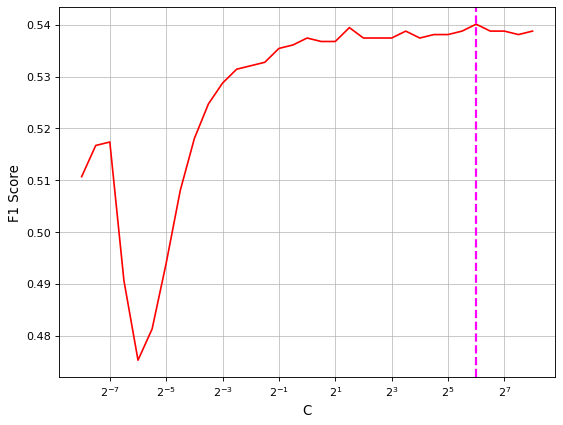

In [18]:
fig,ax1 = plt.subplots(figsize = (8,6))

plt_1 = ax1.plot(x_param_C,y_mean_f1,color='red')

ax1.set_xscale("log",base=2)
ax1.set_xlabel("C")
ax1.set_ylabel("F1 Score")
ax1.tick_params(axis ='y') 

ax1.grid(alpha = 0.75)

ax1.axvline(x=best_C, color = "magenta", linewidth = 2, linestyle = "--",
            label = f"C' = {best_C:.4f}")

plt.show()

### AUC performance at best C

In [19]:
# refit with best C
params = {
    'random_state': 42,
    'C': 0.125,
    'penalty': 'l1',
    'solver': 'liblinear'
}

log_model_l1_Cprime = LogisticRegression(**params).fit(X_train,y_train)

y_pred = log_model_l1_Cprime.predict(X_test)
f1_score(y_true=y_test, y_pred=y_pred, pos_label=1)

0.644793152639087

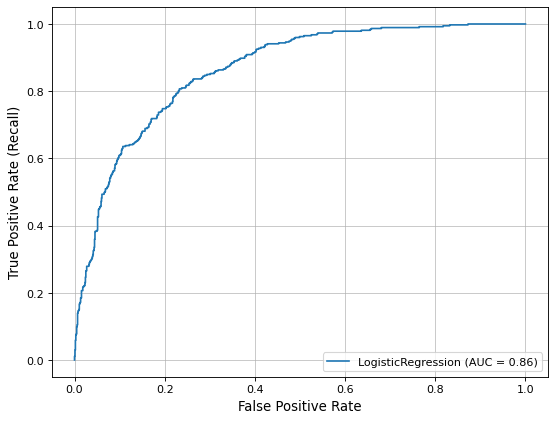

In [20]:
fig,ax = plt.subplots(figsize = (8,6))
RocCurveDisplay.from_estimator(log_model_l1_Cprime, X_test, y_test,ax = ax)

ax.set_ylabel('True Positive Rate (Recall)')
ax.set_xlabel('False Positive Rate')
ax.grid(alpha = 0.75)
plt.show()

## Visualising feature influence on churn using LL coefficients

IndexError: index 30 is out of bounds for axis 0 with size 30

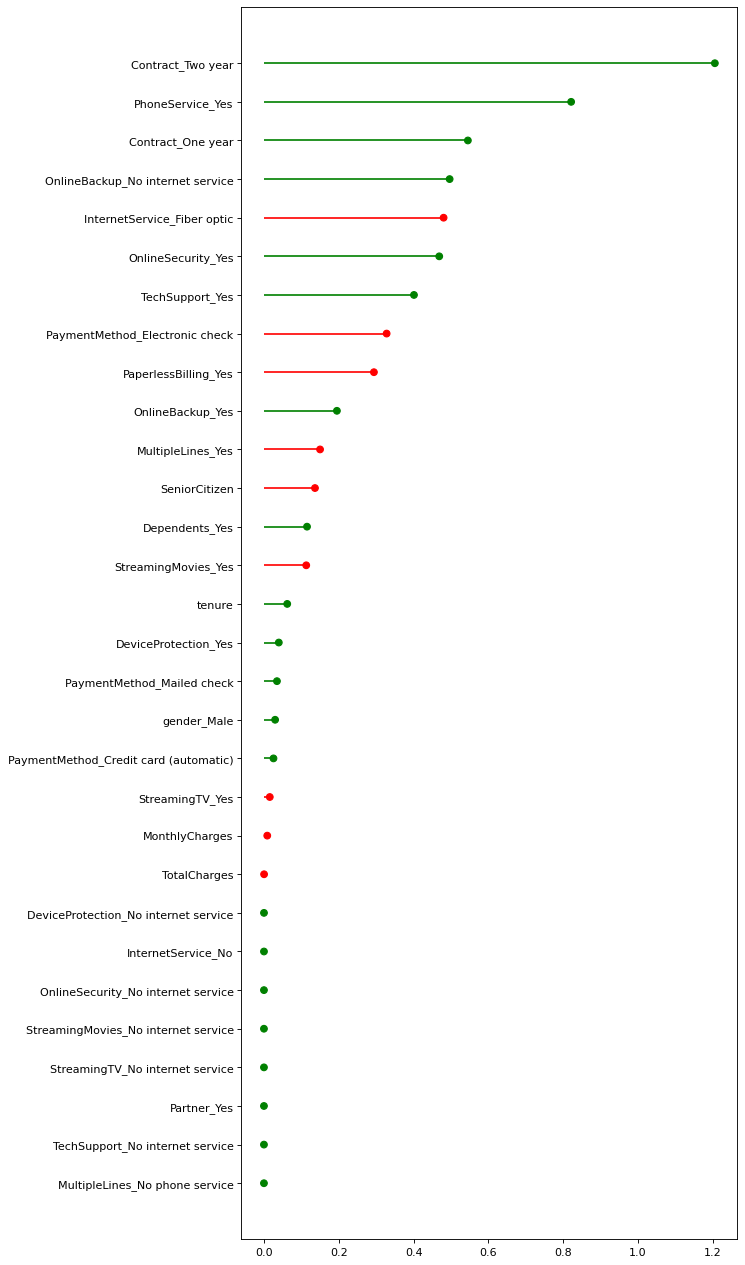

In [22]:
from matplotlib.lines import Line2D

## reshape coefficients into 1D array
coefficients = log_model_l1_Cprime.coef_.reshape([30])
tmp = [] ## empty array to fill with indicators

for coef in coefficients:
    if coef > 0:
        tmp.append(1) ## indicates positive coefficient
    elif coef < 0:
        tmp.append(-1) ## indicates negative coefficient
    else:
        tmp.append(0)

## Create dataframe of features and coefficients for plotting
colnames = X_train.columns
coef_df = pd.DataFrame({"feature": colnames,
                        "coef": np.abs(coefficients),
                        "influence": tmp}).sort_values("coef",ascending = True)


fig, ax = plt.subplots(figsize = (8,20))

## colour red for increased likelihood of cancellation, green otherwise
colors = np.where(coef_df['influence']==1, 'r', 'g') 

ax.scatter(coef_df["coef"],coef_df["feature"],c = colors) ## plot 

for i in range(45):
    ## add a stem to each point
    name = coef_df["feature"].to_numpy()[i]
    val = coef_df["coef"].to_numpy()[i]

    ## match stem colour to the colour of the point
    if coef_df["influence"].to_numpy()[i] == 1:
        ax.hlines(name,xmin = 0, xmax = val,colors = "r")
    else:
        ax.hlines(name,xmin = 0, xmax = val,colors = "g")

## set scale and insert legend
ax.set_xscale("log")
legend_elements = [Line2D([0], [0], color='r', label="More likely to churn"),
                   Line2D([0], [0], color='g', label='Less likely to churn')]

ax.legend(handles=legend_elements,fontsize = 12)
ax.grid(alpha =.75)

ax.set_xlabel("Absolute Value of the Coefficient")
plt.show()


### Single function for automating gridsearch

In [61]:
@ignore_warnings(category=ConvergenceWarning)
def loglasso_gridsearch(X_train):
    fone_score = make_scorer(f1_score, pos_label=0)
    
    param_grid = {
        'C': 2**np.linspace(-8,8,num=33,endpoint=True).astype(np.float16)
    }

    # Redefine the regressor with new parameters
    params = {
        'random_state': 42,
        'penalty': 'l1',
        'solver': 'liblinear'
    }

    regr = LogisticRegression(**params)

    scores = {
        'f1_score': fone_score,
    }

    log_model_cv = GridSearchCV(regr,param_grid,scoring=scores,n_jobs=-1,cv=5,verbose=0,
                                refit=False)

    log_model_cv.fit(X_train,y_train)
    
    log_model_cv_results_df = pd.DataFrame(log_model_cv.cv_results_)
    
    x_param_C = log_model_cv_results_df.param_C.to_numpy().flatten()

    y_mean_f1 = log_model_cv_results_df.mean_test_f1_score.to_numpy().flatten()
    
    index_max = int(np.unique(np.where(y_mean_f1==max(y_mean_f1)))[0])
    
    best_params = {
        'random_state': 42,
        'C': x_param_C[index_max],
        'penalty': 'l1',
        'solver': 'liblinear'
    }
    
    return best_params

In [45]:
best_params = loglasso_gridsearch(X_train)

In [62]:
log_model_l1_Cprime = LogisticRegression(**best_params).fit(X_train,y_train)

y_pred = log_model_l1_Cprime.predict(X_test)
f1_score(y_true=y_test, y_pred=y_pred, pos_label=0)

0.881132075471698

# Grad Boost Bayesian Hyperparameter Search

In [26]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV, space, plots
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from skopt.utils import use_named_args

## Loading in churn set using dummies

In [30]:
X_train = pd.read_csv(r'X_train_churn.csv')
y_train = pd.read_csv(r'y_train_churn.csv')
y_train = np.ravel(y_train)

X_test = pd.read_csv(r'X_test_churn.csv')
y_test = pd.read_csv(r'y_test_churn.csv')
y_test = np.ravel(y_test)

## Solving a min optimization problem to get params

In [31]:
n_features = X_train.shape[1]

clf = GradientBoostingClassifier()

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
search_space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(search_space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="f1"))

In [32]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, search_space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=-0.9678'

In [33]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3],
                            res_gp.x[4]))

Best parameters:
- max_depth=3
- learning_rate=0.158666
- max_features=51
- min_samples_split=91
- min_samples_leaf=33


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

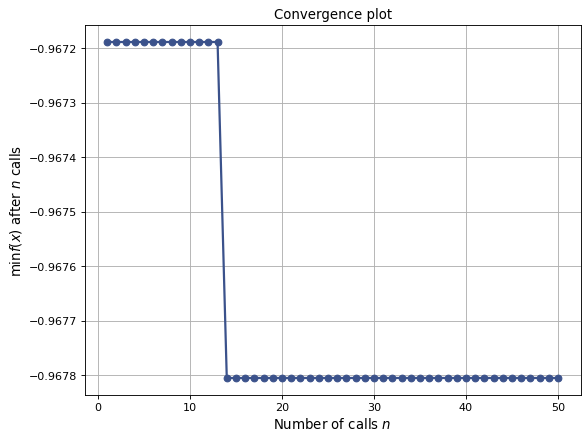

In [34]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

## Using Bayesian Search to get params

In [5]:
clf = GradientBoostingClassifier(random_state=42)

# params = {
#     'learning_rate': space.Real(1e-5, 1, prior = 'log-uniform'),
#     'n_estimators': space.Integer(20, 1_500),
#     'subsample': space.Real(0.05, 1),
#     'max_depth': space.Integer(1, 10),
# }

param_space = {
    'n_estimators': space.Integer(10, 200),
    'learning_rate': space.Real(1e-5, 1.0, 'log-uniform'),
    'subsample': space.Real(0.05, 1),
    'max_depth': space.Integer(1, 10),
    'min_samples_split': space.Integer(2, 20),
    'min_samples_leaf': space.Integer(1, 10),
}

search = BayesSearchCV(clf, param_space, n_iter = 40, cv = 5, scoring = 'f1',
                       refit = False, verbose = 0)

search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
              n_iter=40, refit=False, scoring='f1',
              search_spaces={'learning_rate': Real(low=1e-05, high=1.0, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=200, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.05, high=1, prior='uniform', transform='normalize')})

In [7]:
search.best_params_

OrderedDict([('learning_rate', 0.2659442120572218),
             ('max_depth', 1),
             ('min_samples_leaf', 1),
             ('min_samples_split', 5),
             ('n_estimators', 94),
             ('subsample', 0.11187719551352499)])

In [6]:
clf = GradientBoostingClassifier(**search.best_params_)
model = clf.fit(X_train, y_train)

y_pred = model.predict(X_test)

fone_score_ = f1_score(y_true=y_test, y_pred=y_pred,)
val_acc = accuracy_score(y_true=y_test, y_pred=y_pred)

print(f"F1 score: {fone_score_}, Val Acc: {val_acc}")

F1 score: 0.5956204379562045, Val Acc: 0.8034066713981547


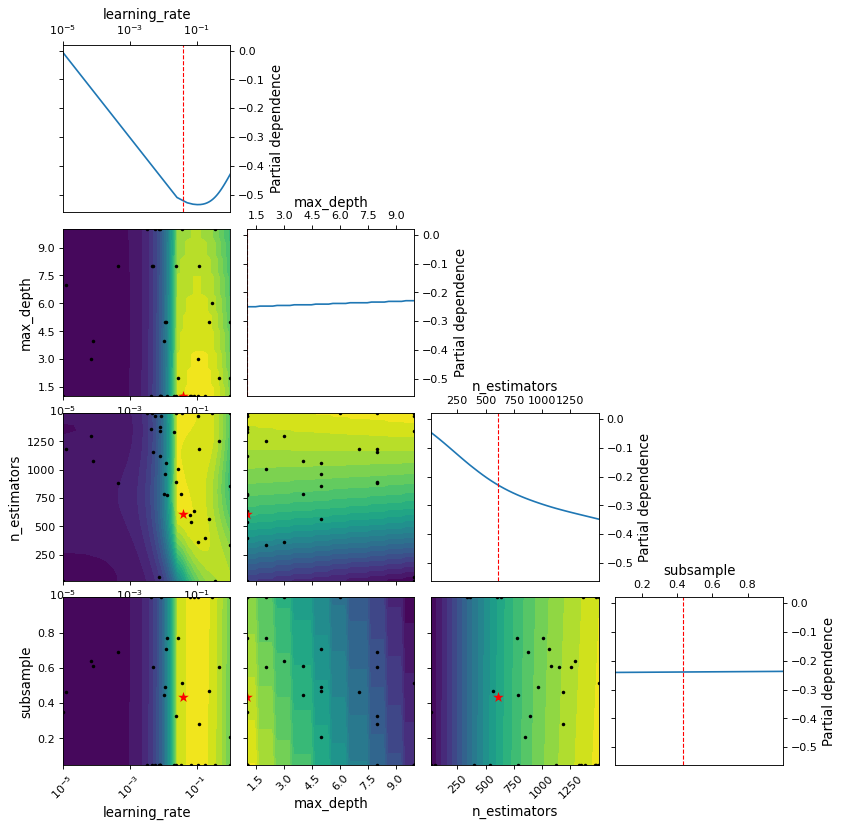

In [26]:
plots.plot_objective(search.optimizer_results_[0],
                     size = 2.5, levels = 25)
plt.show()